# Introduction 

My Kaggle attempt to classify cats and dogs. This notebook can be run directly in Kaggle platform by importing it there.

Some Updates compared to off-line version:
- full data has been used to train model

# Imports

In [1]:
import numpy as np 
import pandas as pd 
import os

import random
import shutil

import zipfile

import tensorflow as tf
print(f"TF version is: {tf.__version__}")

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [25]:
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/dogs-vs-cats/test1.zip
/kaggle/input/dogs-vs-cats/train.zip
/kaggle/input/dogs-vs-cats/sampleSubmission.csv


In [5]:
local_zip = '/kaggle/input/dogs-vs-cats/train.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [6]:
train_path = '/train'
f_names = os.listdir(train_path)
print(f"count of data points: {len(f_names)}")

count of data points: 25000


Split data to train and validation sets:

In [7]:
random.seed(1)
split_ratio = 0.8
sample_data = random.sample(f_names, len(f_names))
train_sample  = sample_data[:int(split_ratio * len(f_names))]
validation_sample = sample_data[int(split_ratio * len(f_names)):]


Create sub directories for train and validation classes and copy files into correct directories:

In [11]:
# Directory with training cat/dog pictures
train_cats_dir = '/train/cat'
train_dogs_dir = '/train/dog'

# Directory with validation cat/dog pictures
validation_cats_dir = '/validation/cat'
validation_dogs_dir = '/validation/dog'

# create directories:
os.makedirs(train_dogs_dir,exist_ok = True)
os.makedirs(train_cats_dir,exist_ok = True)
os.makedirs(validation_dogs_dir,exist_ok = True)
os.makedirs(validation_cats_dir,exist_ok = True)

# copy the data:
# train data:
for v in train_sample:
    if 'cat' in v.lower():
        shutil.copy('/train/'+ v,'/train/cat/'+ v)
    else:
         shutil.copy('/train/' + v,'/train/dog/' + v)

# validation data:
for v in validation_sample:
    if 'cat' in v.lower():
        shutil.copy('/train/'+ v,'/validation/cat/'+ v)
    else:
        shutil.copy('/train/'+ v,'/validation/dog/'+ v)

print(f'count of cats in training: {len(os.listdir(train_cats_dir))}')
print(f'count of dogs in training: {len(os.listdir(train_dogs_dir))}')

In [18]:
model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2,2),
    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2), 
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(), 
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'), 
    # Only 1 output neuron. It will contain a value from 0-1 where 0 for 1 class ('cats') and 1 for the other ('dogs')
    tf.keras.layers.Dense(1, activation='sigmoid')  
])

2022-12-01 01:05:33.775550: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [19]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18496)             0

In [20]:
from tensorflow.keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics = ['accuracy'])

In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# All images will be rescaled by 1./255.
train_datagen = ImageDataGenerator( rescale = 1.0/255. )
test_datagen  = ImageDataGenerator( rescale = 1.0/255. )

# --------------------
# Flow training images in batches of 20 using train_datagen generator
# --------------------
train_generator = train_datagen.flow_from_directory('/train',
                                                    batch_size=20,
                                                    class_mode='binary',
                                                    target_size=(150, 150))     
# --------------------
# Flow validation images in batches of 20 using test_datagen generator
# --------------------
validation_generator =  test_datagen.flow_from_directory('/validation',
                                                         batch_size=20,
                                                         class_mode  = 'binary',
                                                         target_size = (150, 150))


Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [23]:
history = model.fit(
            train_generator,
            epochs=15,
            validation_data=validation_generator,
            verbose=2
            )

2022-12-01 01:08:22.069782: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/15
1000/1000 - 251s - loss: 0.6005 - accuracy: 0.6835 - val_loss: 0.4976 - val_accuracy: 0.7712
Epoch 2/15
1000/1000 - 229s - loss: 0.4676 - accuracy: 0.7776 - val_loss: 0.4561 - val_accuracy: 0.7998
Epoch 3/15
1000/1000 - 223s - loss: 0.4127 - accuracy: 0.8170 - val_loss: 0.4599 - val_accuracy: 0.7794
Epoch 4/15
1000/1000 - 214s - loss: 0.3686 - accuracy: 0.8426 - val_loss: 0.4031 - val_accuracy: 0.8304
Epoch 5/15
1000/1000 - 219s - loss: 0.3331 - accuracy: 0.8622 - val_loss: 0.3846 - val_accuracy: 0.8406
Epoch 6/15
1000/1000 - 213s - loss: 0.3044 - accuracy: 0.8776 - val_loss: 0.4126 - val_accuracy: 0.8306
Epoch 7/15
1000/1000 - 216s - loss: 0.2829 - accuracy: 0.8913 - val_loss: 0.4435 - val_accuracy: 0.8342
Epoch 8/15
1000/1000 - 220s - loss: 0.2714 - accuracy: 0.8964 - val_loss: 0.4434 - val_accuracy: 0.8338
Epoch 9/15
1000/1000 - 213s - loss: 0.2557 - accuracy: 0.9021 - val_loss: 0.5356 - val_accuracy: 0.8370
Epoch 10/15
1000/1000 - 219s - loss: 0.2551 - accuracy: 0.9038 -

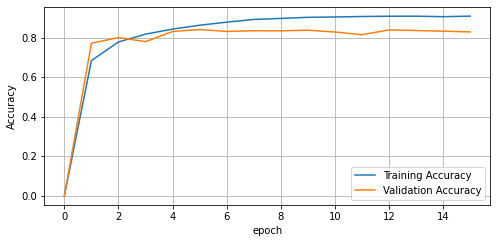

In [27]:
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
y1 = [0]+history.history['accuracy']
y2 = [0]+history.history['val_accuracy']
plt.plot(y1, label='Training Accuracy')
plt.plot(y2, label='Validation Accuracy')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Predicting the test data:

In [ ]:
local_zip = '/kaggle/input/dogs-vs-cats/test1.zip'
zip_ref   = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/')
zip_ref.close()

In [35]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img
import numpy as np
from tqdm import tqdm

f_names = os.listdir('/test1')
labels =[]
ids=[]

for v in tqdm(f_names):    
    img=load_img('/test1/' + v, target_size=(150, 150))
    x = img_to_array(img)
    x = x /255
    x=np.expand_dims(x, axis=0)
    images = np.vstack([x])
    
    ids.append(int(v.rsplit( ".", 1 )[ 0 ]))
    
    if model.predict(images, batch_size=10) > 0.5:
        labels.append(1)
    else:
        labels.append(0)

100%|██████████| 12500/12500 [17:12<00:00, 12.10it/s]


In [38]:
import pandas as pd
df_sub = pd.DataFrame({'id':[],'label':[]})
df_sub['id']=ids
df_sub['label']= labels
print(df_sub.shape)
df_sub.head()
# save the dataframe:
sub_name = 'cat_dog_predictions_simple_cnn.csv'
df_sub.to_csv('/kaggle/working/'+sub_name)

(12500, 2)
